#Final B3 - Grupo 1

Análisis de DF de clientes bancarios para detectar bajas en un periodo de dos meses aplicando modelos predictivos.

Notebook 1/3 = Preparación

Integrantes:

Pascuccio, José (1017995)

Bugarin Carlos Maximiliano (82125)

Calda Ariel Gustavo (1158887)

Capello Juan Andrés (1158799)

Ricci Cecilia (1160479)

Siracusa Angel Jonatán (1160480)

Nievas Ivana (1157295)


##**Importación de librerías**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Grupo1/B3/Final'


Mounted at /content/drive


## **Carga inicial del DF**

In [ ]:
df = pd.read_csv(path +'/MESES_hasta_201404.zip')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,47,81,83) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## **Limpieza inicial sobre el csv**

In [ ]:
# Filtro los 3 últimos meses
df2=df[df.foto_mes > 201401].copy()
df2.head()

,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo
5,3333,201403,.,0,455,0,0,16109631.53,-1.253631e+08,2362829.57,...,.,.,.,.,.,.,.,S,S,.
6,3333,201403,.,0,455,0,0,1450087.77,-4.760275e+06,966073.49,...,.,.,.,.,.,.,.,S,S,.
7,3333,201404,0,0,455,0,0,-1351755.68,-1.069960e+07,276455.04,...,.,.,.,.,.,.,.,S,S,.
8,3333,201404,0,0,455,0,0,2451895.62,-1.524554e+08,-569108.17,...,.,.,.,.,.,.,.,S,S,.
22,5609788,201402,0,0,224,61,237,0.00,9.669420e+03,0.00,...,0,20140227,0,-20743.77,1467.03,19970317,377.24,S,N,3229.2


## **Tratamiento de columnas fecha**

In [ ]:
mask = ((df2['foto_mes'].astype('str')==df2['Master_fechaalta'].str[:6]) | (df2['foto_mes'].astype('str')==df2['Visa_fechaalta'].str[:6])) 
df2['alta_tarj_mes'] = np.where(mask, 1, 0)
df2 = df2.drop(['Master_fechaalta','Visa_fechaalta','Visa_Fvencimiento', 'Master_Fvencimiento'], axis='columns')

In [ ]:
mask = (df2['Master_fultimo_cierre']=='.')
print(df2[mask]['Master_fultimo_cierre'].head(10))
df2.loc[df2[mask].index, ['Master_fultimo_cierre']]=df2[mask]['foto_mes']*100 + 15
print(df2[mask]['Master_fultimo_cierre'].head(10))

5      .
6      .
7      .
8      .
106    .
107    .
108    .
170    .
171    .
172    .
Name: Master_fultimo_cierre, dtype: object
5      20140315
6      20140315
7      20140415
8      20140415
106    20140215
107    20140315
108    20140415
170    20140215
171    20140315
172    20140415
Name: Master_fultimo_cierre, dtype: object


In [ ]:
mask = (df2['Visa_fultimo_cierre']=='.')
print(df2[mask]['Visa_fultimo_cierre'].head(10))
df2.loc[df2[mask].index, ['Visa_fultimo_cierre']]=df2[mask]['foto_mes']*100 + 15
print(df2[mask]['Visa_fultimo_cierre'].head(10))

5      .
6      .
7      .
8      .
106    .
107    .
108    .
445    .
446    .
447    .
Name: Visa_fultimo_cierre, dtype: object
5      20140315
6      20140315
7      20140415
8      20140415
106    20140215
107    20140315
108    20140415
445    20140215
446    20140315
447    20140415
Name: Visa_fultimo_cierre, dtype: object


## **Creación de variable objetivo**

In [ ]:
# Creo un lag (lo voy a usar para crear la variable objetivo)
df2['Mes_1'] = df2.groupby(['numero_de_cliente'])['foto_mes'].shift(-1)
df2['Mes_2'] = df2.groupby(['numero_de_cliente'])['foto_mes'].shift(-2)

In [ ]:
# Despues de crear el lag puedo descartar foto_mes > 201402
df2=df2[df2.foto_mes == 201402]

In [ ]:
#Verifico el formato de la tabla
df2[['numero_de_cliente', 'foto_mes', 'Mes_1', 'Mes_2']].head(10)

,numero_de_cliente,foto_mes,Mes_1,Mes_2
22,5609788,201402,201403.0,201404.0
38,5609981,201402,201403.0,201404.0
54,5610023,201402,201403.0,201404.0
70,5610089,201402,201403.0,201404.0
86,5610101,201402,201403.0,201404.0
102,5610189,201402,201403.0,201404.0
106,5610328,201402,201403.0,201404.0
122,5610521,201402,201403.0,201404.0
138,5610637,201402,201403.0,201404.0
154,5610791,201402,201403.0,201404.0


In [ ]:
df2['target'] = "Continua"
df2.loc[(df2['Mes_2'].isnull()), 'target'] = "Baja+2"
df2.loc[(df2['Mes_1'].isnull()), 'target'] = "Baja+1"

In [ ]:
df2['target_bin'] = np.where(df2['target']=='Baja+2', 1, 0)

In [ ]:
df2[df2['target_bin']==1]['numero_de_cliente'].count()

778

In [ ]:
print(df2.shape)
df2 = df2.drop(['Mes_1' , 'Mes_2', 'target'] , axis='columns')
print(df2.shape)

(181981, 170)
(181981, 167)


### Limpieza completa del CSV

#### Chequeamos que columnas tienen valores iguales a lo largo de todo el dataset

In [ ]:
df2['marketing_activo_ultimos90dias'] = df2['marketing_activo_ultimos90dias'].astype(int)

In [ ]:
for c in df2.columns:
    if len(df2[c].unique())==1:
        print(f'{c}={df2[c].unique()}')

foto_mes=[201402]
marketing_activo_ultimos90dias=[0]
mcomisiones=[0.]
mactivos_margen=[0.]
mpasivos_margen=[0.]
tpaquete_premium=['S']
tpaquete3=['N']
tpaquete5=['N']
tpaquete8=['N']
mcuenta_corriente_dolares=[0.]
mbonos_gobierno=[0]
mmonedas_extranjeras=[0]
minversiones_otras=[0]
tplan_sueldo=['N']
mplan_sueldo=[0.]
ccuenta_descuentos=[0]
mcuenta_descuentos=[0]
thomebanking=['N']
chomebanking_transacciones=[0]
tautoservicio=['N']
cautoservicio_transacciones=[0]
tcajas_consultas=['N']


In [ ]:
col_drop_1 = []
for c in df2.columns:
    if ((c!='foto_mes') & (len(df2[c].unique())==1)):
        col_drop_1.append(c)

print(df2.shape) 
df2 = df2.drop(col_drop_1 , axis='columns')
print(f'Eliminadas columnas: {col_drop_1}')        
print(df2.shape)  

(181981, 167)
Eliminadas columnas: ['marketing_activo_ultimos90dias', 'mcomisiones', 'mactivos_margen', 'mpasivos_margen', 'tpaquete_premium', 'tpaquete3', 'tpaquete5', 'tpaquete8', 'mcuenta_corriente_dolares', 'mbonos_gobierno', 'mmonedas_extranjeras', 'minversiones_otras', 'tplan_sueldo', 'mplan_sueldo', 'ccuenta_descuentos', 'mcuenta_descuentos', 'thomebanking', 'chomebanking_transacciones', 'tautoservicio', 'cautoservicio_transacciones', 'tcajas_consultas']
(181981, 146)


In [ ]:
for c in df2.columns:
    a = df2[c].unique().tolist()
    if (len(a)==2) & (a.count('S')==1):
        print(f'{c}={a}')


tpaquete2=['N', 'S']
tpaquete4=['N', 'S']
tpaquete6=['N', 'S']
tpaquete7=['N', 'S']
tpaquete9=['N', 'S']
tcuentas=['S', 'N']
tcuenta_corriente=['S', 'N']
tcaja_ahorro=['S', 'N']
ttarjeta_debito=['S', 'N']
ttarjeta_visa=['S', 'N']
ttarjeta_master=['S', 'N']
tplazo_fijo=['N', 'S']
tfondos_comunes_inversion=['N', 'S']
ttitulos=['N', 'S']
tseguro_vida_mercado_abierto=['N', 'S']
tseguro_auto=['N', 'S']
tseguro_vivienda=['N', 'S']
tseguro_accidentes_personales=['N', 'S']
tcaja_seguridad=['N', 'S']
tcuenta_debitos_automaticos=['N', 'S']
ttarjeta_visa_debitos_automatico=['S', 'N']
ttarjeta_master_debitos_automati=['N', 'S']
tpagodeservicios=['N', 'S']
tpagomiscuentas=['N', 'S']
tcambio_monedas=['N', 'S']
tcallcenter=['N', 'S']
tcajas=['S', 'N']
tcajas_depositos=['S', 'N']
tcajas_extracciones=['N', 'S']
tcajas_otras=['N', 'S']
tmovimientos_ultimos90dias=['S', 'N']
Master_tconsumos=['N', 'S']
Master_tadelantosefectivo=['N', 'S']
Visa_tconsumos=['S', 'N']
Visa_tadelantosefectivo=['N', 'S']


In [ ]:
# Esto solo se puede hacer en las columnas binarias (de 2 valores)
for c in df2.columns:
    a = df2[c].unique().tolist()
    if (len(a)==2) & (a.count('S')==1):
        df2[c] = np.where(df2[c]=='S', 1, 0)

In [ ]:
#Chequeamos lo modificado
for c in df2.columns:
    a = df2[c].unique().tolist()
    if len(a)==2:
        print(f'{c}={a}')

cliente_vip=[0, 1]
tpaquete2=[0, 1]
tpaquete4=[0, 1]
tpaquete6=[0, 1]
tpaquete7=[0, 1]
tpaquete9=[0, 1]
tcuentas=[1, 0]
tcuenta_corriente=[1, 0]
tcaja_ahorro=[1, 0]
mdescubierto_preacordado=[1.17, 0.0]
ttarjeta_debito=[1, 0]
ttarjeta_visa=[1, 0]
ttarjeta_master=[1, 0]
tplazo_fijo=[0, 1]
tfondos_comunes_inversion=[0, 1]
ttitulos=[0, 1]
tseguro_vida_mercado_abierto=[0, 1]
tseguro_auto=[0, 1]
tseguro_vivienda=[0, 1]
tseguro_accidentes_personales=[0, 1]
tcaja_seguridad=[0, 1]
tcuenta_debitos_automaticos=[0, 1]
ttarjeta_visa_debitos_automatico=[1, 0]
ttarjeta_master_debitos_automati=[0, 1]
tpagodeservicios=[0, 1]
tpagomiscuentas=[0, 1]
tcambio_monedas=[0, 1]
tcallcenter=[0, 1]
tcajas=[1, 0]
tcajas_depositos=[1, 0]
tcajas_extracciones=[0, 1]
tcajas_otras=[0, 1]
tmovimientos_ultimos90dias=[1, 0]
Master_Finiciomora=[nan, 2.0]
Master_tconsumos=[0, 1]
Master_tadelantosefectivo=[0, 1]
Visa_Finiciomora=[nan, 2.0]
Visa_tconsumos=[1, 0]
Visa_tadelantosefectivo=[0, 1]
alta_tarj_mes=[0, 1]
target_bin=

In [ ]:
columnas_limpiar = pd.DataFrame(df2)
missings_columnas_limpiar = columnas_limpiar.isnull().sum() * 100 / len(columnas_limpiar)
listado_missing_columnas_limpiar = pd.DataFrame({'column_name': columnas_limpiar.columns,
                                 'missings_columnas_limpiar': missings_columnas_limpiar})
listado_missing_columnas_limpiar.sort_values('missings_columnas_limpiar', ascending = False, inplace=True)
listado_missing_columnas_limpiar.head()

,column_name,missings_columnas_limpiar
Master_Finiciomora,Master_Finiciomora,99.236184
Visa_Finiciomora,Visa_Finiciomora,99.141669
numero_de_cliente,numero_de_cliente,0.000000
ccajeros_propio_transacciones,ccajeros_propio_transacciones,0.000000
tcallcenter,tcallcenter,0.000000


#### Verificamos las columnas nulas

In [ ]:
nulos=df2.isnull().sum()
np.round((nulos[nulos>1]/len(df2))*100,2)

Master_Finiciomora    99.24
Visa_Finiciomora      99.14
dtype: float64

In [ ]:
# Eliminamos estas dos columnas
# Master_Finiciomora  99.24% de NaN
# Visa_Finiciomora    99.14% de NaN
df2 = df2.drop(['Master_Finiciomora' , 'Visa_Finiciomora'] , axis='columns')

In [ ]:
for c in df2.columns:
    if len(df2[c].unique())==1:
        print(f'{c}={df2[c].unique()}')

foto_mes=[201402]


In [ ]:
df2.head(5)

,numero_de_cliente,foto_mes,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,marketing_coss_selling,tpaquete2,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo,alta_tarj_mes,target_bin
22,5609788,201402,0,224,61,237,0.00,9669.42,8,0,...,20140227,0,-20743.77,1467.03,377.24,1,0,3229.2,0,0
38,5609981,201402,0,227,64,196,0.00,4107.16,9,0,...,20140227,0,-713.7,0,706.14,1,0,748.8,0,0
54,5610023,201402,0,536,41,91,0.00,2888.84,9,0,...,20140227,0,-1881.83,0,361.64,1,0,93.6,0,0
70,5610089,201402,0,545,0,237,2597.43,0.00,12,0,...,20140227,0,-7631.25,0,6017.28,1,0,1673.1,0,0
86,5610101,201402,0,1217,49,45,0.00,46303.03,11,0,...,20140227,0,-18960.01,1514.84,1050.96,1,0,304.2,0,0


In [ ]:
df2.shape

(181981, 144)

In [ ]:
with pd.option_context('display.max_rows', len(df2.columns.values), 'display.max_columns', 1):
    display(df2.dtypes)

numero_de_cliente                     int64
foto_mes                              int64
cliente_vip                           int64
cliente_sucursal                      int64
cliente_edad                          int64
cliente_antiguedad                    int64
mrentabilidad                       float64
mrentabilidad_annual                float64
marketing_coss_selling                int64
tpaquete2                             int64
tpaquete4                             int64
tpaquete6                             int64
tpaquete7                             int64
tpaquete9                             int64
tcuentas                              int64
tcuenta_corriente                     int64
mcuenta_corriente_Nopaquete         float64
mcuenta_corriente_Paquete           float64
tcaja_ahorro                          int64
mcaja_ahorro_Paquete                float64
mcaja_ahorro_Nopaquete              float64
mcaja_ahorro_dolares                float64
mdescubierto_preacordado        

## **Transformación del DF**

In [ ]:
print(df2.groupby(['Master_marca_atraso'])['Master_marca_atraso'].count())
print(df2.groupby(['Master_cuenta_estado'])['Master_cuenta_estado'].count())
print(df2.groupby(['Visa_marca_atraso'])['Visa_marca_atraso'].count())
print(df2.groupby(['Visa_cuenta_estado'])['Visa_cuenta_estado'].count())

Master_marca_atraso
.     25543
0    155048
1      1390
Name: Master_marca_atraso, dtype: int64
Master_cuenta_estado
.      25543
10    155811
11       209
12       286
19       132
Name: Master_cuenta_estado, dtype: int64
Visa_marca_atraso
.     10463
0    169956
1      1562
Name: Visa_marca_atraso, dtype: int64
Visa_cuenta_estado
.      10463
10    170758
11       250
12       362
19       148
Name: Visa_cuenta_estado, dtype: int64


In [ ]:
print(df2.shape)        
df2= pd.get_dummies(df2, columns=["Master_marca_atraso","Master_cuenta_estado", \
                                                      "Visa_marca_atraso","Visa_cuenta_estado"], \
                              prefix=["MMA","MCE","VMA","VCE"])
print(df2.shape)

(181981, 144)
(181981, 156)


In [ ]:
print(df2.shape)   
drop_cols= ['MMA_.', 'MCE_.','VMA_.','VCE_.']
df2 = df2.drop(drop_cols , axis='columns')
print(df2.shape) 

(181981, 156)
(181981, 152)


In [ ]:
df2['mprestamos_hipotecarios'].replace({".": "0"}, inplace=True)
df2['mcuenta_debitos_automaticos'].replace({".": "0"}, inplace=True)
df2['mttarjeta_visa_debitos_automatic'].replace({".": "0"}, inplace=True)
df2['mttarjeta_master_debitos_automat'].replace({".": "0"}, inplace=True)
df2['mpagodeservicios'].replace({".": "0"}, inplace=True)
df2['mpagomiscuentas'].replace({".": "0"}, inplace=True)
df2['Master_mfinanciacion_limite'].replace({".": "0"}, inplace=True)
df2['Master_msaldototal'].replace({".": "0"}, inplace=True)
df2['Master_msaldopesos'].replace({".": "0"}, inplace=True)
df2['Master_msaldodolares'].replace({".": "0"}, inplace=True)
df2['Master_mconsumospesos'].replace({".": "0"}, inplace=True)
df2['Master_mconsumosdolares'].replace({".": "0"}, inplace=True)
df2['Master_mlimitecompra'].replace({".": "0"}, inplace=True)
df2['Master_madelantopesos'].replace({".": "0"}, inplace=True)
df2['Master_madelantodolares'].replace({".": "0"}, inplace=True)
df2['Master_mpagado'].replace({".": "0"}, inplace=True)
df2['Master_mpagospesos'].replace({".": "0"}, inplace=True)
df2['Master_mpagosdolares'].replace({".": "0"}, inplace=True)
df2['Master_mconsumototal'].replace({".": "0"}, inplace=True)
df2['Master_mpagominimo'].replace({".": "0"}, inplace=True)
df2['Visa_mfinanciacion_limite'].replace({".": "0"}, inplace=True)
df2['Visa_msaldototal'].replace({".": "0"}, inplace=True)
df2['Visa_msaldopesos'].replace({".": "0"}, inplace=True)
df2['Visa_msaldodolares'].replace({".": "0"}, inplace=True)
df2['Visa_mconsumospesos'].replace({".": "0"}, inplace=True)
df2['Visa_mconsumosdolares'].replace({".": "0"}, inplace=True)
df2['Visa_mlimitecompra'].replace({".": "0"}, inplace=True)
df2['Visa_madelantopesos'].replace({".": "0"}, inplace=True)
df2['Visa_madelantodolares'].replace({".": "0"}, inplace=True)
df2['Visa_mpagado'].replace({".": "0"}, inplace=True)
df2['Visa_mpagospesos'].replace({".": "0"}, inplace=True)
df2['Visa_mpagosdolares'].replace({".": "0"}, inplace=True)
df2['Visa_mconsumototal'].replace({".": "0"}, inplace=True)
df2['Visa_mpagominimo'].replace({".": "0"}, inplace=True)
df2['mtarjeta_visa_descuentos'].replace({".": "0"}, inplace=True)
df2['mtarjeta_master_descuentos'].replace({".": "0"}, inplace=True)


In [ ]:
buscaPunto =df2.isin(['.']).any()
TienenPunto = buscaPunto[buscaPunto == True]
print(TienenPunto)

Series([], dtype: bool)


In [ ]:
 df2.select_dtypes('object').columns

Index(['mprestamos_hipotecarios', 'mcuenta_debitos_automaticos',
       'mttarjeta_visa_debitos_automatic', 'mttarjeta_master_debitos_automat',
       'mpagodeservicios', 'mpagomiscuentas', 'mtarjeta_visa_descuentos',
       'mtarjeta_master_descuentos', 'Master_mfinanciacion_limite',
       'Master_msaldototal', 'Master_msaldopesos', 'Master_msaldodolares',
       'Master_mconsumospesos', 'Master_mconsumosdolares',
       'Master_mlimitecompra', 'Master_madelantopesos',
       'Master_madelantodolares', 'Master_fultimo_cierre', 'Master_mpagado',
       'Master_mpagospesos', 'Master_mpagosdolares', 'Master_mconsumototal',
       'Master_mpagominimo', 'Visa_mfinanciacion_limite', 'Visa_msaldototal',
       'Visa_msaldopesos', 'Visa_msaldodolares', 'Visa_mconsumospesos',
       'Visa_mconsumosdolares', 'Visa_mlimitecompra', 'Visa_madelantopesos',
       'Visa_madelantodolares', 'Visa_fultimo_cierre', 'Visa_mpagado',
       'Visa_mpagospesos', 'Visa_mpagosdolares', 'Visa_mconsumototal',
 

In [ ]:
df2['Master_mfinanciacion_limite'] = df2['Master_mfinanciacion_limite'].astype(float)
df2['Master_msaldototal'] = df2['Master_msaldototal'].astype(float)
df2['Master_msaldopesos'] = df2['Master_msaldopesos'].astype(float)
df2['Master_msaldodolares'] = df2['Master_msaldodolares'].astype(float)
df2['Master_mconsumospesos'] = df2['Master_mconsumospesos'].astype(float)
df2['Master_mconsumosdolares'] = df2['Master_mconsumosdolares'].astype(float)
df2['Master_mlimitecompra'] = df2['Master_mlimitecompra'].astype(float)
df2['Master_madelantopesos'] = df2['Master_madelantopesos'].astype(float)
df2['Master_madelantodolares'] = df2['Master_madelantodolares'].astype(float)
df2['Master_mpagado'] = df2['Master_mpagado'].astype(float)
df2['Master_mpagospesos'] = df2['Master_mpagospesos'].astype(float)
df2['Master_mpagosdolares'] = df2['Master_mpagosdolares'].astype(float)
df2['Master_mconsumototal'] = df2['Master_mconsumototal'].astype(float)
df2['Master_mpagominimo'] = df2['Master_mpagominimo'].astype(float)
df2['Visa_mfinanciacion_limite'] = df2['Visa_mfinanciacion_limite'].astype(float)
df2['Visa_msaldototal'] = df2['Visa_msaldototal'].astype(float)
df2['Visa_msaldopesos'] = df2['Visa_msaldopesos'].astype(float)
df2['Visa_msaldodolares'] = df2['Visa_msaldodolares'].astype(float)
df2['Visa_mconsumospesos'] = df2['Visa_mconsumospesos'].astype(float)
df2['Visa_mconsumosdolares'] = df2['Visa_mconsumosdolares'].astype(float)
df2['Visa_mlimitecompra'] = df2['Visa_mlimitecompra'].astype(float)
df2['Visa_madelantopesos'] = df2['Visa_madelantopesos'].astype(float)
df2['Visa_madelantodolares'] = df2['Visa_madelantodolares'].astype(float)
df2['Visa_mpagado'] = df2['Visa_mpagado'].astype(float)
df2['Visa_mpagospesos'] = df2['Visa_mpagospesos'].astype(float)
df2['Visa_mpagosdolares'] = df2['Visa_mpagosdolares'].astype(float)
df2['Visa_mconsumototal'] = df2['Visa_mconsumototal'].astype(float)
df2['Visa_mpagominimo'] = df2['Visa_mpagominimo'].astype(float)
df2['mprestamos_hipotecarios'] = df2['mprestamos_hipotecarios'].astype(float) 
df2['mcuenta_debitos_automaticos'] = df2['mcuenta_debitos_automaticos'].astype(float)
df2['mttarjeta_visa_debitos_automatic'] = df2['mttarjeta_visa_debitos_automatic'].astype(float) 
df2['mttarjeta_master_debitos_automat'] = df2['mttarjeta_master_debitos_automat'].astype(float)
df2['mpagodeservicios'] = df2['mpagodeservicios'].astype(float) 
df2['mpagomiscuentas'] = df2['mpagomiscuentas'].astype(float) 
df2['mtarjeta_visa_descuentos'] = df2['mtarjeta_visa_descuentos'].astype(float)
df2['mtarjeta_master_descuentos'] = df2['mtarjeta_master_descuentos'].astype(float)


In [ ]:
 df2.select_dtypes('object').columns

Index(['Master_fultimo_cierre', 'Visa_fultimo_cierre'], dtype='object')

In [ ]:
df2 = df2.drop(['Master_fultimo_cierre' , 'Visa_fultimo_cierre'] , axis='columns')
print(df2.shape) 


(181981, 150)


In [ ]:
with pd.option_context('display.max_rows', len(df2.columns.values), 'display.max_columns', 1):
    display(df2.dtypes)


numero_de_cliente                     int64
foto_mes                              int64
cliente_vip                           int64
cliente_sucursal                      int64
cliente_edad                          int64
cliente_antiguedad                    int64
mrentabilidad                       float64
mrentabilidad_annual                float64
marketing_coss_selling                int64
tpaquete2                             int64
tpaquete4                             int64
tpaquete6                             int64
tpaquete7                             int64
tpaquete9                             int64
tcuentas                              int64
tcuenta_corriente                     int64
mcuenta_corriente_Nopaquete         float64
mcuenta_corriente_Paquete           float64
tcaja_ahorro                          int64
mcaja_ahorro_Paquete                float64
mcaja_ahorro_Nopaquete              float64
mcaja_ahorro_dolares                float64
mdescubierto_preacordado        

In [ ]:
df2.head(5)


,numero_de_cliente,foto_mes,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,marketing_coss_selling,tpaquete2,...,MCE_10,MCE_11,MCE_12,MCE_19,VMA_0,VMA_1,VCE_10,VCE_11,VCE_12,VCE_19
22,5609788,201402,0,224,61,237,0.00,9669.42,8,0,...,1,0,0,0,1,0,1,0,0,0
38,5609981,201402,0,227,64,196,0.00,4107.16,9,0,...,1,0,0,0,1,0,1,0,0,0
54,5610023,201402,0,536,41,91,0.00,2888.84,9,0,...,1,0,0,0,1,0,1,0,0,0
70,5610089,201402,0,545,0,237,2597.43,0.00,12,0,...,1,0,0,0,1,0,1,0,0,0
86,5610101,201402,0,1217,49,45,0.00,46303.03,11,0,...,1,0,0,0,1,0,1,0,0,0


In [ ]:
print(df2.shape)

(181981, 150)


**Conclusión Limpieza DF**

Luego de limpiar el DF, salvar todos los registros nulos y borrar columnas que consideramos que no aportaban información valiosa para este estudio guardamos este DF de 150 columnas para usarlo posteriormente en otros notebooks.

In [ ]:
df150 = df2.copy()

# Guardamos este DF de 150 Columnas para levantarlo después desde otro notebook
df2.to_csv(path + '/DF150.csv')


## **Selección y extracción de columnas (Feature selection / extration)**

Tomando como base el DF anterior de 150 columnas vemos de limitar el número de columnas perdiendo poco o nada de información. Sospechamos que un menor número de columnas acelerará el entrenamiento de los diferentes modelos. 

### **Selección de columnas principales vía RFE**

Vamos a entrenar un Random Forest con el estimador RFE (Recursive Feature Extractor) y que el modelo nos diga qué columnas son las que considera más importantes.

### **Creamos los set de train y test**

In [ ]:
X = df2.drop(['target_bin'], axis='columns')
y = df2.target_bin

print(X.shape)
print(y.shape)

(181981, 149)
(181981,)


In [ ]:
# Hacemos un Random Forest con Cross Validation
rf = RandomForestClassifier(n_estimators=5, max_depth=7, random_state=1)
rfecv = RFECV(estimator=rf, step=7, min_features_to_select=70, cv=StratifiedKFold(5), scoring='roc_auc', verbose=1)

rfecv.fit(X,y)


Fitting estimator with 149 features.
Fitting estimator with 142 features.
Fitting estimator with 135 features.
Fitting estimator with 128 features.
Fitting estimator with 121 features.
Fitting estimator with 114 features.
Fitting estimator with 107 features.
Fitting estimator with 100 features.
Fitting estimator with 93 features.
Fitting estimator with 86 features.
Fitting estimator with 79 features.
Fitting estimator with 72 features.
Fitting estimator with 149 features.
Fitting estimator with 142 features.
Fitting estimator with 135 features.
Fitting estimator with 128 features.
Fitting estimator with 121 features.
Fitting estimator with 114 features.
Fitting estimator with 107 features.
Fitting estimator with 100 features.
Fitting estimator with 93 features.
Fitting estimator with 86 features.
Fitting estimator with 79 features.
Fitting estimator with 72 features.
Fitting estimator with 149 features.
Fitting estimator with 142 features.
Fitting estimator with 135 features.
Fitting e

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_depth=7, n_estimators=5,
                                       random_state=1),
      min_features_to_select=70, scoring='roc_auc', step=7, verbose=1)

In [ ]:
rfecv.n_features_


149

In [ ]:
# Listado de columnas importantes seleccionadas por el RFE
listacol = X.columns.tolist()
for i in range(X.shape[1]):
  print('Column %d: %s, Selected: %s, Rank: %.d' % (i, listacol[i], rfecv.support_[i], rfecv.ranking_[i]))

Column 0: numero_de_cliente, Selected: True, Rank: 1
Column 1: foto_mes, Selected: True, Rank: 1
Column 2: cliente_vip, Selected: True, Rank: 1
Column 3: cliente_sucursal, Selected: True, Rank: 1
Column 4: cliente_edad, Selected: True, Rank: 1
Column 5: cliente_antiguedad, Selected: True, Rank: 1
Column 6: mrentabilidad, Selected: True, Rank: 1
Column 7: mrentabilidad_annual, Selected: True, Rank: 1
Column 8: marketing_coss_selling, Selected: True, Rank: 1
Column 9: tpaquete2, Selected: True, Rank: 1
Column 10: tpaquete4, Selected: True, Rank: 1
Column 11: tpaquete6, Selected: True, Rank: 1
Column 12: tpaquete7, Selected: True, Rank: 1
Column 13: tpaquete9, Selected: True, Rank: 1
Column 14: tcuentas, Selected: True, Rank: 1
Column 15: tcuenta_corriente, Selected: True, Rank: 1
Column 16: mcuenta_corriente_Nopaquete, Selected: True, Rank: 1
Column 17: mcuenta_corriente_Paquete, Selected: True, Rank: 1
Column 18: tcaja_ahorro, Selected: True, Rank: 1
Column 19: mcaja_ahorro_Paquete, Sel

**Conclusión Feature Extration con RFE**

El RFE seleccionas muchas columnas como importantes: más de 100 Columnas (dependiendo de la corrida ya que hay una componente aleatoria en cómo se contruyen los Random Forest). Esto no baja sensiblemente la cantidad de columnas por lo que buscaremos otra estrategia de selección.

### **Selección y modificación de columnas con PCA**

Vamos a usar PCA (Principal Components Analysis) para ver cuantos componentes se necesitan para conservar el 95% de la información.

In [ ]:
# Antes de aplicar PCA se escala en DF usando StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


In [ ]:
# Aplicamos PCA al array escalado
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)


PCA()

Componentes necesarios para 95% Varianza: 100


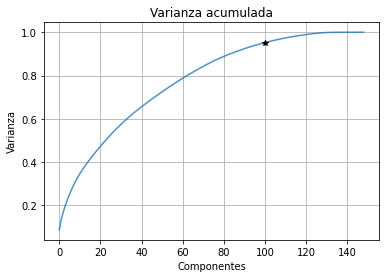

In [ ]:
# Vemos cuantos componentes necesitamos para retener el 95% de la info
suma = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(suma >= 0.95)
print('Componentes necesarios para 95% Varianza: ' + str(d))

plt.plot(range(0,149),np.cumsum(pca.explained_variance_ratio_), alpha=.8)
plt.plot(d, 0.95, 'g*', c='k')
plt.xlabel('Componentes')
plt.ylabel('Varianza')
plt.grid(True)
plt.title("Varianza acumulada")
plt.show()


**Conclusión Feature Extration con PCA**

PCA nos dice que necesitamos al menos 100 componentes para retener el 95% de la información. Nuevamente esto no baja sensiblemente la cantidad de columnas por lo que buscaremos otra estrategia de selección.

### **Selección y modificación de columnas manualmente**

Vamos a achicar el número de columnas del DF manualmente. Generaremos columnas que sumen varias columnas originales (y borraremos estas), eliminaremos las columnas categóricas (ej.: Tiene tarjeta Visa) ya que los montos asociados explican si tiene tarjeta o no. Esperamos retener la mayor cantidad posible de información con muchas menos columnas.

In [ ]:
df2 = df2.drop(['mrentabilidad', 'marketing_coss_selling', 'tpaquete2', 'tpaquete4', 'tpaquete6', 'tpaquete7', 'tpaquete9'] , axis='columns')
df2 = df2.drop(['tcuentas', 'tcuenta_corriente', 'tcaja_ahorro', 'ttarjeta_debito', 'ttarjeta_visa', 'ttarjeta_master'] , axis='columns')
df2 = df2.drop(['cprestamos_personales', 'cprestamos_prendarios', 'cprestamos_hipotecarios', 'tplazo_fijo', 'tfondos_comunes_inversion'] , axis='columns')
df2 = df2.drop(['ttitulos', 'ttarjeta_visa_debitos_automatico', 'ttarjeta_master_debitos_automati', 'tpagodeservicios', 'tpagomiscuentas'] , axis='columns')
df2 = df2.drop(['ccajeros_propios_descuentos', 'ctarjeta_visa_descuentos', 'ctarjeta_master_descuentos', 'ccomisiones_mantenimiento'] , axis='columns')
df2 = df2.drop(['ccomisiones_otras', 'tcambio_monedas', 'ccambio_monedas_compra', 'ccambio_monedas_venta'] , axis='columns')
df2 = df2.drop(['ctransferencias_recibidas', 'ctransferencias_emitidas', 'cextraccion_autoservicio', 'ccheques_depositados'] , axis='columns')
df2 = df2.drop(['ccheques_emitidos', 'ccheques_depositados_rechazados', 'ccheques_emitidos_rechazados', 'tcallcenter'] , axis='columns')


In [ ]:
df2 = df2.drop(['ccajeros_propio_transacciones', 'ccajeros_ajenos_transacciones', 'tcajas', 'tcajas_depositos'] , axis='columns')
df2 = df2.drop(['tcajas_extracciones', 'tcajas_otras', 'Master_msaldopesos', 'Master_msaldodolares', 'Visa_msaldopesos'] , axis='columns')
df2 = df2.drop(['Visa_msaldodolares', 'Master_mpagado', 'Master_mpagospesos', 'Master_mpagosdolares', 'Master_mconsumototal'] , axis='columns')
df2 = df2.drop(['Master_tconsumos', 'Master_tadelantosefectivo', 'Master_mpagominimo', 'Visa_mpagado', 'Visa_mpagospesos'] , axis='columns')
df2 = df2.drop(['Visa_mpagosdolares', 'Visa_mconsumototal', 'Visa_tconsumos', 'Visa_tadelantosefectivo', 'Visa_mpagominimo', 'alta_tarj_mes'] , axis='columns')
print(df2.shape) 


(181981, 86)


In [ ]:
# Creo variables sumando items similares y borrando las columnas originales

df2['mcuentas_all'] = (df2['mcuenta_corriente_Nopaquete'] + df2['mcuenta_corriente_Paquete']
                       + df2['mcaja_ahorro_Paquete'] + df2['mcaja_ahorro_Nopaquete'] + 8 * df2['mcaja_ahorro_dolares']
                       + df2['mplazo_fijo_pesos'] + 8 * df2['mplazo_fijo_dolares'])
df2 = df2.drop(['mcuenta_corriente_Nopaquete', 'mcuenta_corriente_Paquete', 'mcaja_ahorro_Paquete', 'mcaja_ahorro_Nopaquete'], axis='columns')
df2 = df2.drop(['mcaja_ahorro_dolares', 'mplazo_fijo_pesos', 'mplazo_fijo_dolares'], axis='columns')

df2 = df2.drop(['ctarjeta_visa_transacciones', 'ctarjeta_master_transacciones'], axis='columns')
df2 = df2.drop(['Master_mconsumospesos', 'Master_mconsumosdolares', 'Visa_mconsumospesos', 'Visa_mconsumosdolares'], axis='columns')

df2['mtarjeta_consumo_all'] = df2['mtarjeta_visa_consumo'] + df2['mtarjeta_master_consumo']
df2 = df2.drop(['mtarjeta_visa_consumo', 'mtarjeta_master_consumo'], axis='columns')

df2['mprestamos_all'] = df2['mprestamos_personales'] + df2['mprestamos_prendarios'] + df2['mprestamos_hipotecarios']
df2 = df2.drop(['mprestamos_personales', 'mprestamos_prendarios', 'mprestamos_hipotecarios'], axis='columns')

df2['mfondos_inversion_all'] = df2['mfondos_comunes_inversion_pesos'] + 8 * df2['mfondos_comunes_inversion_dolare'] + df2['mtitulos']
df2 = df2.drop(['mfondos_comunes_inversion_pesos', 'mfondos_comunes_inversion_dolare', 'mtitulos'], axis='columns')

df2['mpagos_all'] = df2['mpagodeservicios'] + df2['mpagomiscuentas']
df2 = df2.drop(['mpagodeservicios', 'mpagomiscuentas'], axis='columns')

df2['mdebitos_automaticos_all'] = df2['mcuenta_debitos_automaticos'] + df2['mttarjeta_visa_debitos_automatic'] + df2['mttarjeta_master_debitos_automat']
df2 = df2.drop(['mcuenta_debitos_automaticos', 'mttarjeta_visa_debitos_automatic', 'mttarjeta_master_debitos_automat'], axis='columns')
df2 = df2.drop(['mplan_sueldo_manual', 'cplan_sueldo_transaccion', 'tcuenta_debitos_automaticos'], axis='columns')

df2['mdescuentos_all'] = df2['mcajeros_propios_descuentos'] + df2['mtarjeta_visa_descuentos'] + df2['mtarjeta_master_descuentos']
df2 = df2.drop(['mcajeros_propios_descuentos', 'mtarjeta_visa_descuentos', 'mtarjeta_master_descuentos'], axis='columns')

df2['mcomisiones_all'] = df2['mcomisiones_mantenimiento'] + df2['mcomisiones_otras']
df2 = df2.drop(['mcomisiones_mantenimiento', 'mcomisiones_otras'], axis='columns')

df2['mcambio_monedas_all'] = df2['mcambio_monedas_compra'] + df2['mcambio_monedas_venta']
df2 = df2.drop(['mcambio_monedas_compra', 'mcambio_monedas_venta'], axis='columns')

df2['mtransferencias_all'] = df2['mtransferencias_recibidas'] + df2['mtransferencias_emitidas']
df2 = df2.drop(['mtransferencias_recibidas', 'mtransferencias_emitidas'], axis='columns')

df2['mcheques_all'] = df2['mcheques_depositados'] + df2['mcheques_emitidos']
df2 = df2.drop(['mcheques_depositados', 'mcheques_emitidos'], axis='columns')

df2['mcheques_rechazados_all'] = df2['mcheques_depositados_rechazados'] + df2['mcheques_emitidos_rechazados']
df2 = df2.drop(['mcheques_depositados_rechazados', 'mcheques_emitidos_rechazados'], axis='columns')

df2['mcajeros_all'] = df2['mcajeros_propio'] + df2['mcajeros_ajenos']
df2 = df2.drop(['mcajeros_propio', 'mcajeros_ajenos'], axis='columns')

df2['mfinanciacion_limite_all'] = df2['Master_mfinanciacion_limite'] + df2['Visa_mfinanciacion_limite']
df2 = df2.drop(['Master_mfinanciacion_limite', 'Visa_mfinanciacion_limite'], axis='columns')

df2['mtarjeta_saldototal_all'] = df2['Master_msaldototal'] + df2['Visa_msaldototal']
df2 = df2.drop(['Master_msaldototal', 'Visa_msaldototal'], axis='columns')

df2['mlimitecompra_all'] = df2['Master_mlimitecompra'] + df2['Visa_mlimitecompra']
df2 = df2.drop(['Master_mlimitecompra', 'Visa_mlimitecompra'], axis='columns')

df2['mtarjeta_adelanto_all'] = df2['Master_madelantopesos'] + df2['Visa_madelantopesos'] + 8 * df2['Master_madelantodolares'] + 8 * df2['Visa_madelantodolares']
df2 = df2.drop(['Master_madelantopesos', 'Visa_madelantopesos', 'Master_madelantodolares', 'Visa_madelantodolares'], axis='columns')

print(df2.shape) 

(181981, 49)


In [ ]:
df2 = df2.drop(['MMA_0', 'MMA_1', 'MCE_10', 'MCE_11', 'MCE_12', 'MCE_19'] , axis='columns')
df2 = df2.drop(['VMA_0', 'VMA_1', 'VCE_10', 'VCE_11', 'VCE_12', 'VCE_19'] , axis='columns')
print(df2.shape) 


In [ ]:
df2['tseguro_vida_mercado_abierto'] = df2['tseguro_vida_mercado_abierto'].astype(bool)
df2['tseguro_auto'] = df2['tseguro_auto'].astype(bool)
df2['tseguro_vivienda'] = df2['tseguro_vivienda'].astype(bool)
df2['tseguro_accidentes_personales'] = df2['tseguro_accidentes_personales'].astype(bool)
df2['tseguro_all'] = df2['tseguro_vida_mercado_abierto'] | df2['tseguro_auto'] | df2['tseguro_vivienda'] | df2['tseguro_accidentes_personales']
df2 = df2.drop(['tseguro_vida_mercado_abierto', 'tseguro_auto', 'tseguro_vivienda', 'tseguro_accidentes_personales'] , axis='columns')
df2['tseguro_all'] = df2['tseguro_all'].astype(int)

df2[['numero_de_cliente', 'tseguro_all']].head(20)


,numero_de_cliente,tseguro_all
22,5609788,0
38,5609981,0
54,5610023,0
70,5610089,1
86,5610101,1
102,5610189,0
106,5610328,0
122,5610521,1
138,5610637,1
154,5610791,0


In [ ]:
print(df2.shape)


(181981, 34)


In [ ]:
with pd.option_context('display.max_rows', len(df2.columns.values), 'display.max_columns', 1):
    display(df2.dtypes)

numero_de_cliente                  int64
foto_mes                           int64
cliente_vip                        int64
cliente_sucursal                   int64
cliente_edad                       int64
cliente_antiguedad                 int64
mrentabilidad_annual             float64
mdescubierto_preacordado         float64
mcuentas_saldo                   float64
ctarjeta_debito_transacciones      int64
mautoservicio                    float64
tcaja_seguridad                    int64
mextraccion_autoservicio         float64
ccallcenter_transacciones          int64
tmovimientos_ultimos90dias         int64
target_bin                         int64
mcuentas_all                     float64
mtarjeta_consumo_all             float64
mprestamos_all                   float64
mfondos_inversion_all            float64
mpagos_all                       float64
mdebitos_automaticos_all         float64
mdescuentos_all                  float64
mcomisiones_all                  float64
mcambio_monedas_

**Conclusión Limpieza DF**

Se logró dejar un DF de 34 columnas con la mayor información posible. Guardamos este DF de 34 columnas para usarlo posteriormente en otros notebooks.

In [ ]:
df34 = df2.copy()

# Guardamos este DF de 34 Columnas para levantarlo después desde otro notebook
df2.to_csv(path + '/DF34.csv')


## **Test de Datasets**

Vamos a tomar los dos DF generados y verificaremos si tienen información similar. Para ello entrenamos un Random Forest con ambos DF y comparamos resultados. 

### **Creamos los set de train y test**

In [ ]:
# Ensayo el DF de 150 columnas
X = df150.drop(['target_bin'], axis='columns')
y = df150.target_bin

print(X.shape)
print(y.shape)

(181981, 149)
(181981,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)


(136485, 149)
(45496, 149)


In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=5, class_weight='balanced', max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, max_leaf_nodes=16,
                       n_estimators=500, n_jobs=-1)

In [ ]:
y_train_pred = rnd_clf.predict(X_train)
y_test_pred = rnd_clf.predict(X_test)

print('DF de 150 columnas')
print('Accuracy: Train: %.3f - Test: %.3f \n' % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
print('Recall: Train: %.3f - Test: %.3f \n' % (recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)))
print('Precision: Train: %.3f - Test: %.3f \n' % (precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)))
print('ROC AUC: Train: %.3f - Test: %.3f \n' % (roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)))


DF de 150 columnas
Accuracy: Train: 0.883 - Test: 0.883 

Recall: Train: 0.851 - Test: 0.813 

Precision: Train: 0.031 - Test: 0.027 

ROC AUC: Train: 0.867 - Test: 0.848 



In [ ]:
# Ensayo el DF de 34 columnas
X = df34.drop(['target_bin'], axis='columns')
y = df34.target_bin

print(X.shape)
print(y.shape)

(181981, 33)
(181981,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)


(136485, 33)
(45496, 33)


In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=5, class_weight='balanced', max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, max_leaf_nodes=16,
                       n_estimators=500, n_jobs=-1)

In [ ]:
y_train_pred = rnd_clf.predict(X_train)
y_test_pred = rnd_clf.predict(X_test)

print('DF de 150 columnas')
print('Accuracy: Train: %.3f - Test: %.3f \n' % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
print('Recall: Train: %.3f - Test: %.3f \n' % (recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)))
print('Precision: Train: %.3f - Test: %.3f \n' % (precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)))
print('ROC AUC: Train: %.3f - Test: %.3f \n' % (roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)))


DF de 150 columnas
Accuracy: Train: 0.874 - Test: 0.873 

Recall: Train: 0.842 - Test: 0.808 

Precision: Train: 0.029 - Test: 0.025 

ROC AUC: Train: 0.858 - Test: 0.840 



**Conclusión Test de Datasets**

Se entrenó el mismo modelo con ambos DF y las métricas que obtuvimos fueron muy parecidas. Concluímos que ambos DF tienen igual cantidad de información respecto del tema que queremos evaluar. Cualquiera de los dos DF puede ser usado para entrenar a los modelos.

Decidimos usar en adelante el DF de 150 columnas (sólo se lo limpió y se corrigieron los faltantes y errores) si el entrenamiento del modelo lo hace posible (computacionalmente hablando). Si se necesitara un DF más liviano se usará el DF de 34 columnas.
